# Построение симплексов

Берется простая логика: у каждого симплекса есть граница

Таким образом: $\partial${1,2,3} = [{1,2},{2,3},{3,1}]

Если нам надо отслеживать появление больших симплексов, значит нам в обратную сторону (ко-границы): [{1,2},{2,3},{3,1}] -> {1,2,3}

И дальше мы так можем генеритьсимплексы всевозможных размеров чисто комбинаторно (страшно предстваить как тогда ищутся гомологии).

Надо посмотреть как разные фильтрации на это влияют

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from tqdm.notebook import trange, tqdm
from scripts import centroids_graph_builder, graph_osm_loader, utils, clustering
import gudhi

from joblib import Parallel, delayed

In [2]:
def plot_simplex(pos, K):
    
    # max dim of simplices
    max_dim = len(K)
    # get positions for points in graph
    # pos = nx.spring_layout(G)
    X = np.array(list(pos.values()))

    plt.figure(figsize=(14, 7))

    def stack(idx):
        ret = np.empty((0, 2))
        for _id in idx:
            point = pos[_id]
            # ret = np.vstack((ret, X[_id,:]))
            ret = np.vstack((ret, point))
        return ret

    # plot vertices
    for v in K[0]:
        point = pos[v]
        plt.scatter(point[0], point[1])

    # plot edges
    if max_dim >= 2:
        for e in K[1]:
            (start_id, end_id) = e
            start_point = pos[start_id]
            end_point = pos[end_id]
            plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'c-', alpha=0.5)

    # plot triangles
    if max_dim >= 3:
        for triangle in K[2]:
            t = plt.Polygon(stack(triangle), color="blue", alpha=0.15)
            plt.gca().add_patch(t)

    plt.show()

In [3]:
from itertools import combinations


def check_simplex_boundaries(simplex : list, simplicial_set : list[list]) -> bool:
    k = len(simplex)
    boundaries = combinations(simplex, r=k-1)
    for b in boundaries:
        if set(b) not in simplicial_set:
            return False
    return True


In [ ]:
G = nx.complete_graph(10)
pos = nx.spring_layout(G)

K = [
    list(G.nodes),
    [set(e) for e in G.edges]
]

Необходимо найти всего лишь два k-1 симплекса, чтобы получить набор вершин для k-симплекса. Дальше просто пускаем проверку

In [4]:
def construct_k_simplex(K, dim_k):
    # To avoid duplicates
    seen_simplex = []
    # Set of boundaries of k-simplices
    k_faces = K[dim_k - 1]
    if len(K) - 1 < dim_k:
        K.append([])
    # Iterate over boundaries
    for face_a in tqdm(k_faces):
        face_a = set(face_a)
        for face_b in k_faces:
            face_b = set(face_b)
            # Find adjacent faces
            if len(set(face_a).intersection(set(face_b))) == dim_k - 1:
                # Create potential candidates
                k_simplex = set(face_a).union(set(face_b))
                # Check if already seen
                if k_simplex not in seen_simplex:
                    seen_simplex.append(k_simplex)
                    # Check if boundaries of this simplex are present in the simplicial complex
                    if check_simplex_boundaries(k_simplex, k_faces):
                        K[dim_k].append(k_simplex)
    return K

  0%|          | 0/1130 [00:00<?, ?it/s]

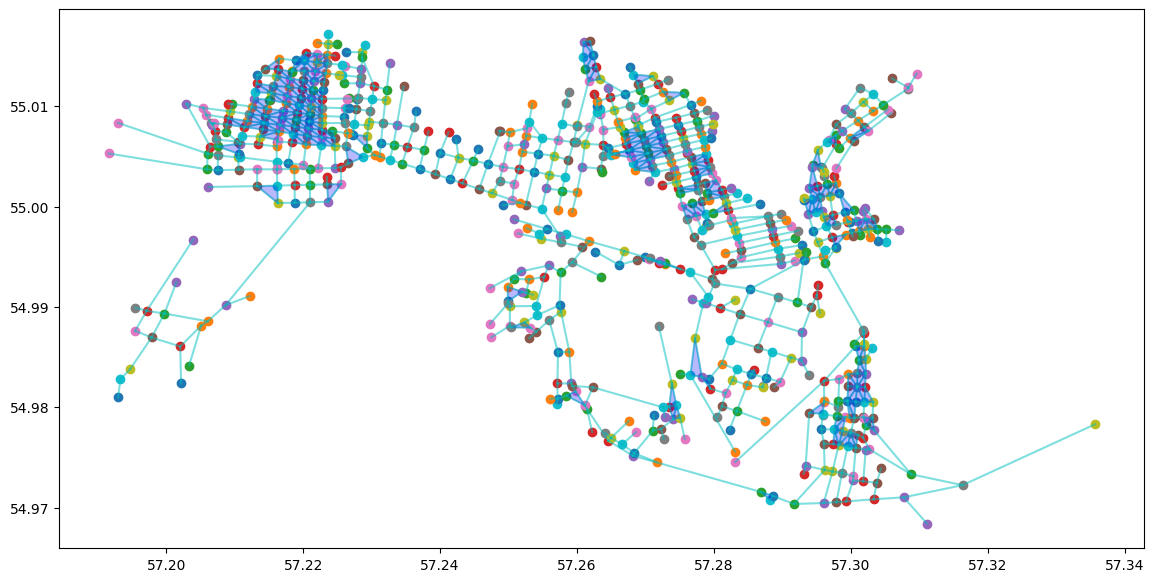

In [16]:
K = construct_k_simplex(K, dim_k=2)

plot_simplex(pos, K)

In [15]:
K = construct_k_simplex(K, dim_k=3)
K[3]


  0%|          | 0/215 [00:00<?, ?it/s]

[]

# Random graph

In [5]:
def find_simplex_birth(simplex, simplicial_complex):
    # Find boundaries of a simplex
    boundaries = combinations(simplex, r=len(simplex)-1)
    birth = 0.0
    # Collect birth time of boundaries
    for b in boundaries:
        b = set(b)
        for s in simplicial_complex:
            if b == set(s[0]):
                # Choose the latest one
                if birth < s[-1]:
                    birth = s[-1]
    return birth


def filtration(G, dim_k=2, weight='weight'):
    # Construct basic simplexes
    K = [
        list(G.nodes), # dim = 0 : vertices
        [set(e) for e in G.edges] # dim = 1 : vertices
        ]
    # Find all simplexes
    for k in range(2, dim_k + 1):
        K = construct_k_simplex(K, dim_k=k)
    
    vertices = [[id, 0.0] for id in K[0]]
    edges = [[set(edge[:-1]), edge[-1][weight]] for edge in G.edges(data=True)]
    edges = sorted(
        edges, 
        key=lambda e : e[-1]
    )
    # Store simplexes alongside with their birth time
    simplicial_complex = [vertices, edges]
    # Now add simplexes from higher dimensions
    for k, subcomplex in enumerate(K[2:]):
        simplex_time = [[
            simplex,
            find_simplex_birth(simplex, simplicial_complex[k+1])
        ] for simplex in subcomplex]
        
        simplex_time = sorted(
            simplex_time, 
            key=lambda s : s[-1]
        )
        simplicial_complex.append(simplex_time)
    
    return simplicial_complex, K

In [ ]:
import random


G = nx.dorogovtsev_goltsev_mendes_graph(n=4)
# G = nx.complete_graph(10) # for computnig dim_k > 2

for (u,v,w) in G.edges(data=True):
    buf = random.randint(1, 100)
    w['weight'] = buf
    w['spring_layout'] = 1 / buf
    
pos = nx.spring_layout(G, weight='spring_layout')

A = nx.adjacency_matrix(G, weight='length').todense()


K = [
        list(G.nodes), # dim = 0 : vertices
        [set(e) for e in G.edges], # dim = 1 : edges
    ]

plot_simplex(pos, K)

In [ ]:
# Launch filtration
simplicial_complex, K = filtration(G, dim_k=3, weight='weight')

# get timestamps
time_thresholds = []
for subcomplex in simplicial_complex:
    for simplex in subcomplex:
        time_thresholds.append(simplex[-1])

time_thresholds = np.unique(time_thresholds)

In [ ]:
step = 2

for t in time_thresholds[::step]:
    subcomplex_t = []
    for subcomplex in simplicial_complex:
        buf = [data[0] for data in subcomplex if data[1] <= t]
        if buf:
            subcomplex_t.append(buf)
    plot_simplex(pos, subcomplex_t)


# City graph

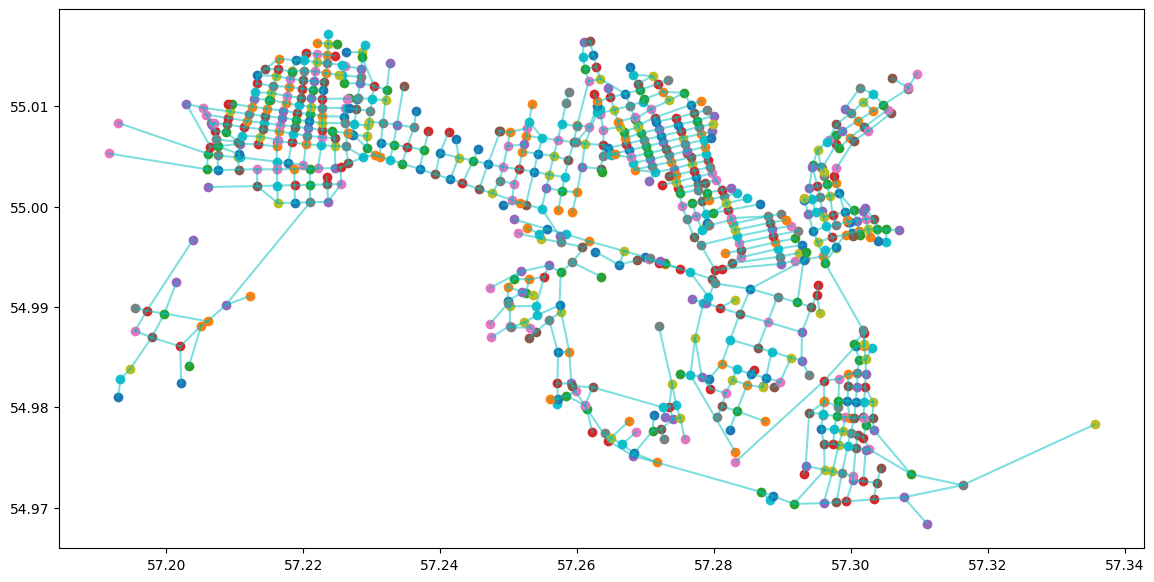

In [27]:
GRAPH_ID = graph_osm_loader.cities['ASHA']

# примеры id есть в graph_osm_loader.py
G = graph_osm_loader.get_graph(GRAPH_ID) # загрузка графа
g = G

pos = {u: [d['x'],d['y']] for u,d in g.nodes(data=True)}

K = [
        list(G.nodes), # dim = 0 : vertices
        list(G.edges), # dim = 1 : edges
    ]
plot_simplex(pos, K)

In [28]:
def get_4(g:nx.Graph,u1,u2):
    n1,n2 = set(g[u1].keys()), set(g[u2].keys())
    l = []
    for u in n1:
        if u in {u1,u2}:
            continue
        for v in n2:
            if v in {u1,u2}:
                continue
            if u == v :
                continue
            if (u,v) in g.edges():
                q = [u1,u,v,u2]
                l.append(q)
    return l
def get_3(g,u1,u2):
    n1,n2 = set(g[u1].keys()), set(g[u2].keys())
    nn = n1.intersection(n2)
    if len(nn) == 0:
        return []
    else:
        l = []
        for u in nn:
            q = [u,u1,u2]
            q.sort()
            l.append(q)
        return l
e = set()
c = set()
for u,v in g.edges():
    for l in get_4(g,u,v):
        p1,p2,p3,p4 = l
        L = g.edges()[p1,p2]['length'] + g.edges()[p2,p3]['length'] + g.edges()[p3,p4]['length']+ g.edges()[p4,p1]['length'] 
        q = [p1,p2,p3,p4]
        q.sort()
        q = tuple(q)
        if L < 900 and q not in c:
            c.add(q)
            e.add((p1,p3))
for p1,p2 in e:
    g.add_edge(p1,p2,length = nx.single_source_dijkstra(g,p1,p2,weight='length')[0])

In [25]:
# Launch filtration
simplicial_complex, K = filtration(G, dim_k=2, weight='length')

# get timestamps
time_thresholds = []
for subcomplex in simplicial_complex:
    for simplex in subcomplex:
        time_thresholds.append(simplex[-1])

time_thresholds = np.unique(time_thresholds)

  0%|          | 0/2154 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
len(time_thresholds)

1131

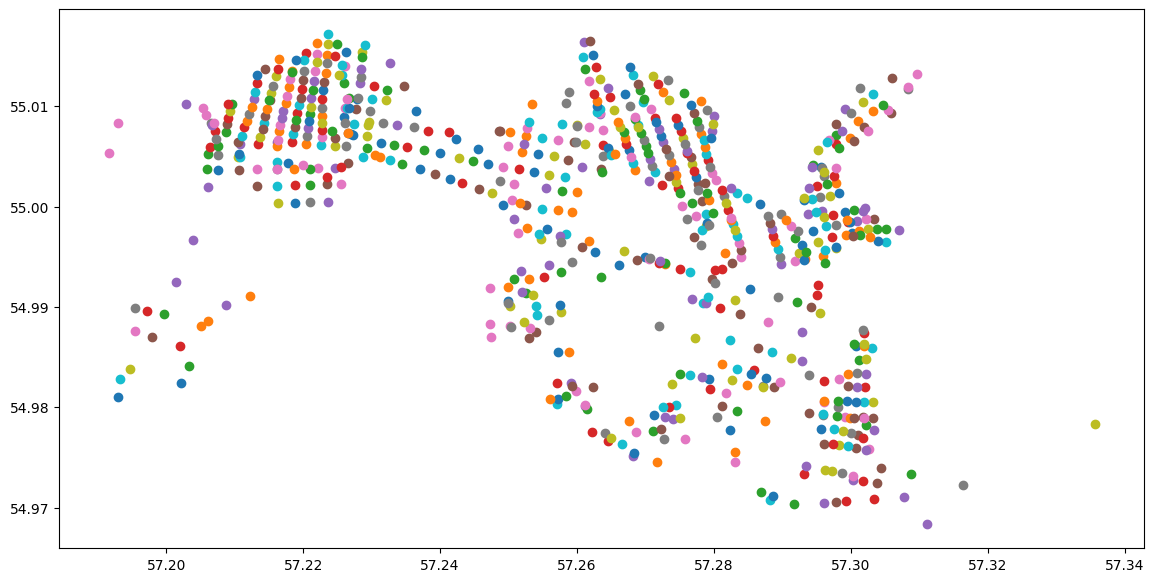

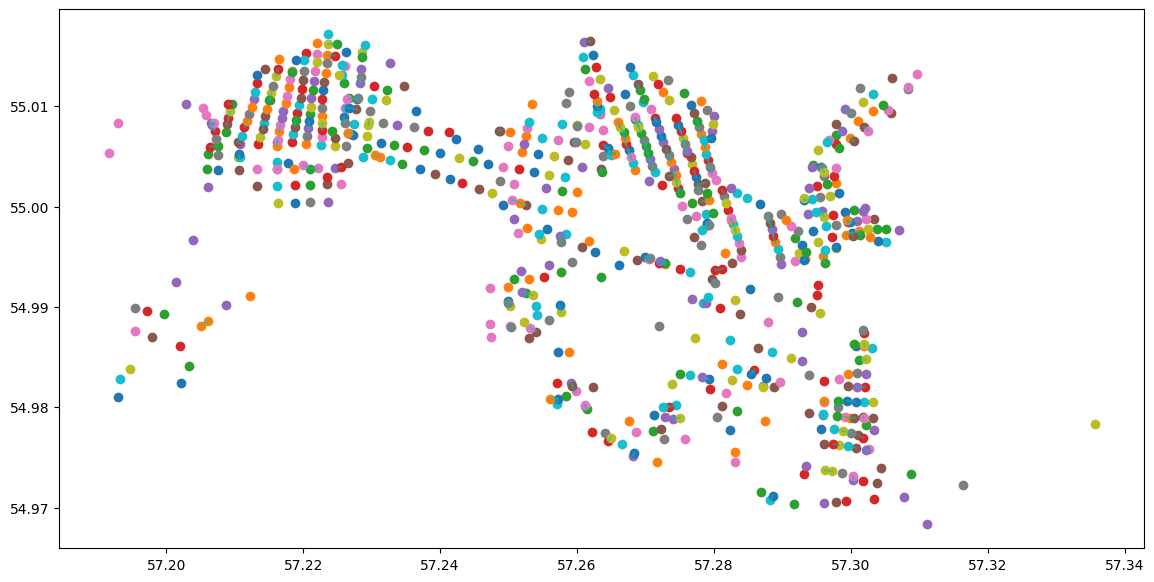

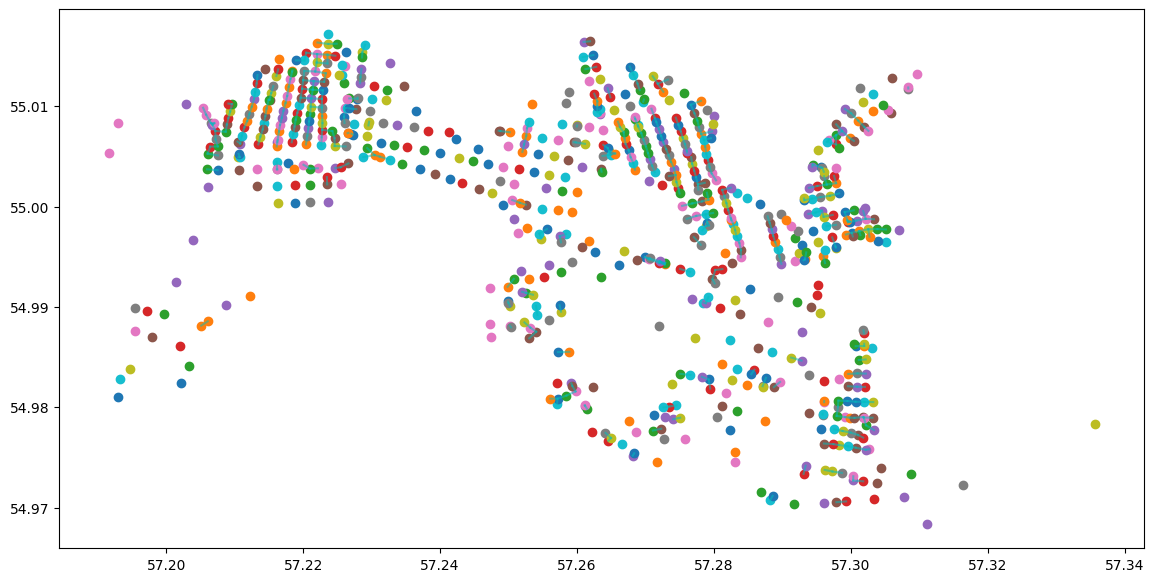

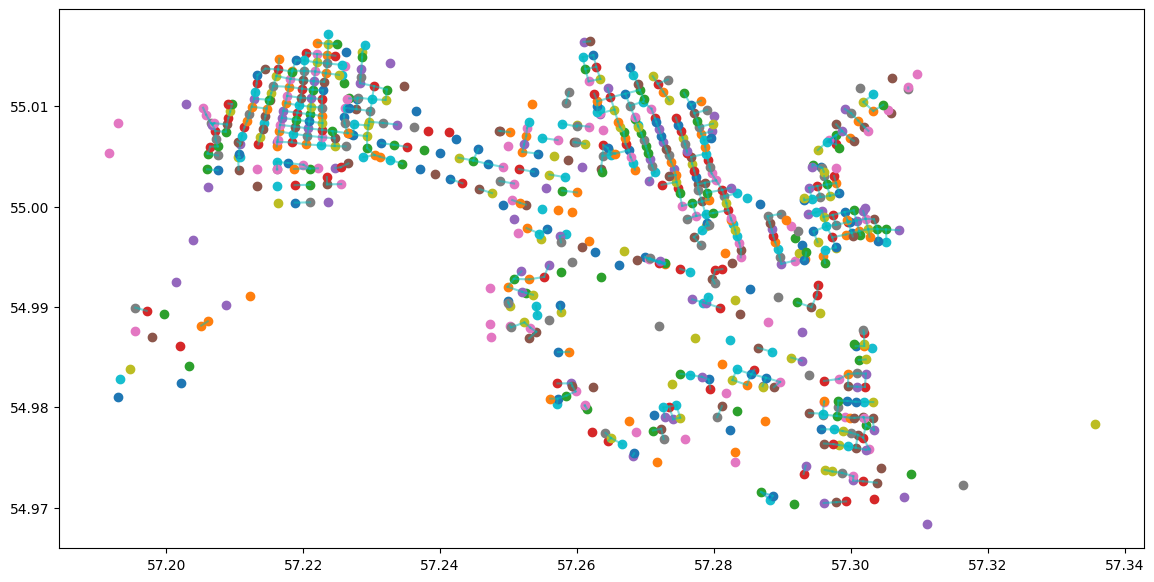

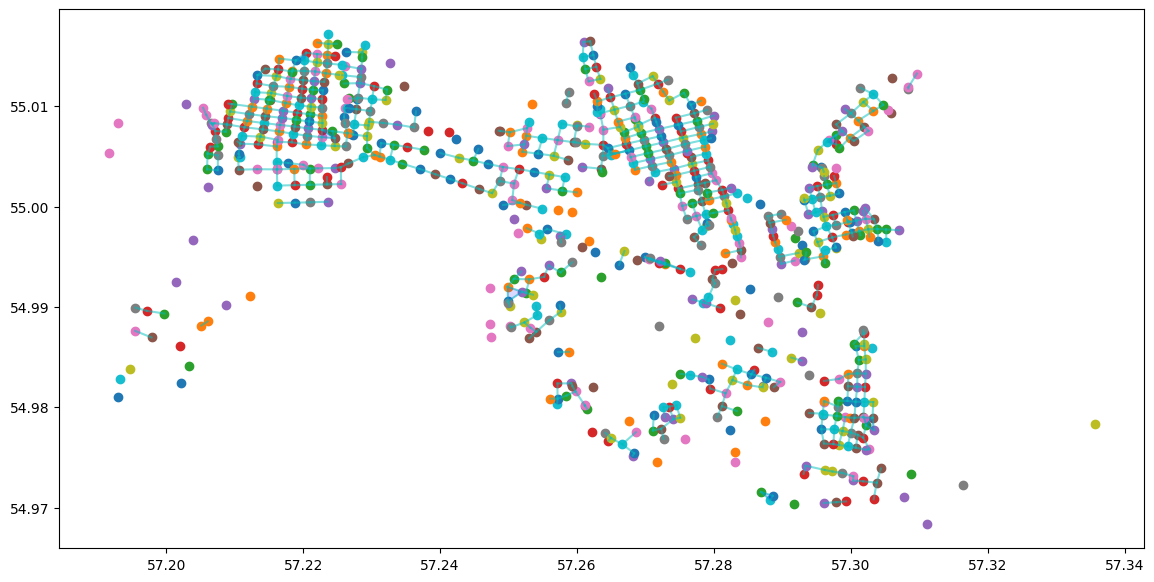

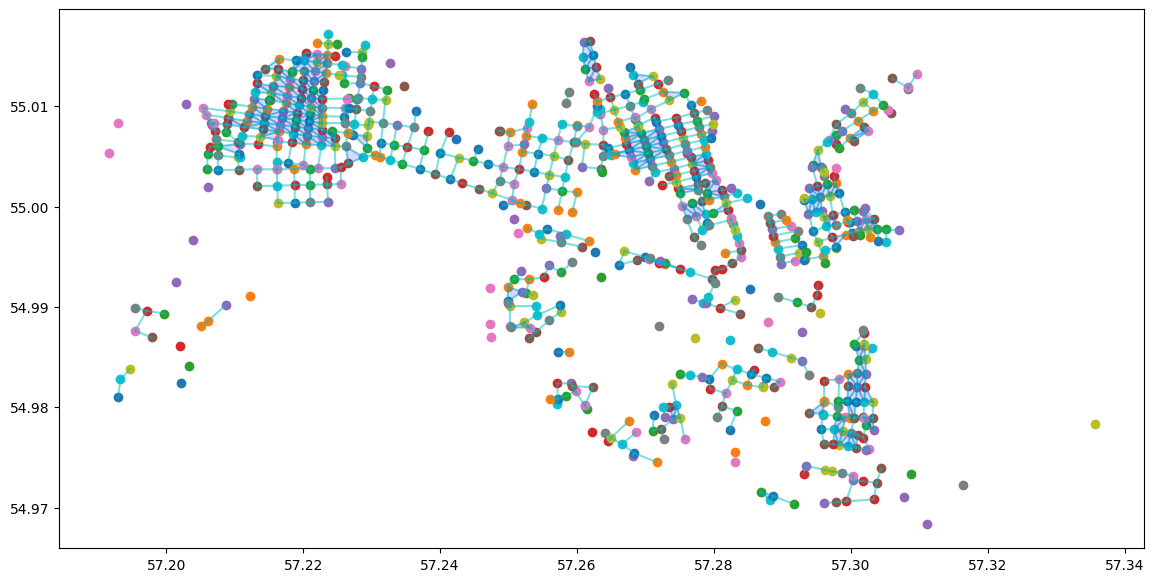

In [14]:
step = 200

for t in time_thresholds[::step]:
    subcomplex_t = []
    for subcomplex in simplicial_complex:
        buf = [data[0] for data in subcomplex if data[1] <= t]
        if buf:
            subcomplex_t.append(buf)
    plot_simplex(pos, subcomplex_t)

  0%|          | 0/1215 [00:00<?, ?it/s]

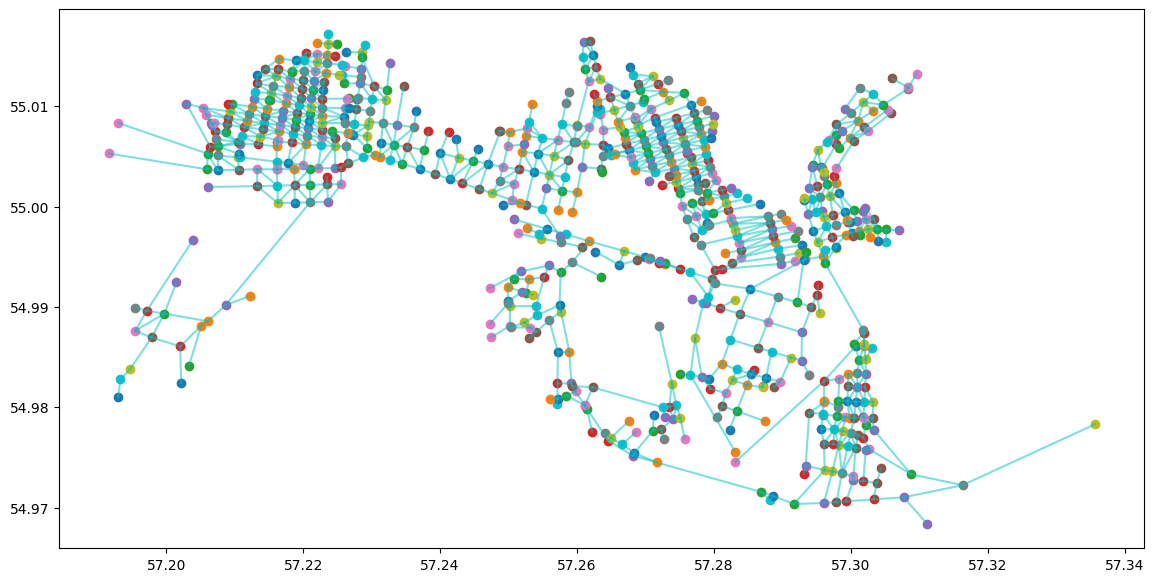

In [30]:
K = [
        list(G.nodes), # dim = 0 : vertices
        list(G.edges), # dim = 1 : edges
    ]
K = construct_k_simplex(K, dim_k=2)
plot_simplex(pos, K)